## 导入包、设置随机数和gpu

In [2]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [3]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  1
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [4]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## 设置PINN模型的各个组件和方法

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [6]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, layers, X_train, X_left, X_right, X_upper, X_lower, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        
        # data
        #将训练数据、上下左右边界转换为tensor，并移动到GPU上
        #X_train的第一列代表x，第二列代表t，代表配位点
        self.x_train = torch.tensor(X_train[:,0:1], requires_grad=True).float().to(device)
        self.t_train = torch.tensor(X_train[:,1:2], requires_grad=True).float().to(device)
        #上下左右边界的第一列代表x，第二列代表t，代表初边界值点
        self.x_left = torch.tensor(X_left[:,0:1], requires_grad=True).float().to(device)
        self.t_left = torch.tensor(X_left[:,1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(X_right[:,0:1], requires_grad=True).float().to(device)
        self.t_right = torch.tensor(X_right[:,1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(X_upper[:,0:1], requires_grad=True).float().to(device)
        self.t_upper = torch.tensor(X_upper[:,1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(X_lower[:,0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(X_lower[:,1:2], requires_grad=True).float().to(device)

        self.x_star = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device) #将X_star的第一列赋值给self.x_star
        self.t_star = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device) #将X_star的第二列赋值给self.t_star
        self.u_star = torch.tensor(u_star).float().to(device) #将传入的u_star和v_star参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u_star和self.v_star来访问这些值。

        
        
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这个值。
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )


        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)


        self.iter = 0 #记录迭代次数，为LBFGS方法服务
        
        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差

        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - 5 * u * (1-u)#计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
        u_pred_right = self.net_u(self.x_right, self.t_right)
        u_pred_upper = self.net_u(self.x_upper, self.t_upper)
        u_pred_lower = self.net_u(self.x_lower, self.t_lower)

        f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

        loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，因为初值条件为u(x,0) = 后面的一串
        loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，因为边界值为u(0,t) = u(2*pi,t) 
        loss_f = torch.mean(f_pred ** 2) #计算loss_f
        
        loss = loss_ic + loss_bc + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1
        
        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star)
           
        error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)

        
        self.test_error.append(error_u_test)
        
        
        return loss #返回总的loss
    

    #神经网络的训练方法，这里训练先使用SGD或者Adam优化器优化nIter次，然后使用LBFGS优化器优化nIterLBFGS次
    def train(self, nIter, nIterLBFGS):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式
                
        # Backward and optimize

        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     u_pred_right = self.net_u(self.x_right, self.t_right)
        #     u_pred_upper = self.net_u(self.x_upper, self.t_upper)
        #     u_pred_lower = self.net_u(self.x_lower, self.t_lower)

        #     f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

        #     loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，定义见论文
        #     loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，定义见论文
        #     loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
            
        #     loss = loss_ic + loss_bc + loss_f #计算总的loss

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

    


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
            u_pred_right = self.net_u(self.x_right, self.t_right)
            u_pred_upper = self.net_u(self.x_upper, self.t_upper)
            u_pred_lower = self.net_u(self.x_lower, self.t_lower)

            f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

            loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，因为初值条件为u(x,0) = 后面的一串
            loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，因为边界值为u(0,t) = u(2*pi,t) 
            loss_f = torch.mean(f_pred ** 2) #计算loss_f
            
            loss = loss_ic + loss_bc + loss_f #计算总的loss
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，无参数，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


            #record the test error
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star)
            
            error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)

            
            self.test_error.append(error_u_test)

        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化



            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    #定义函数获得隐藏层的输出
    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval() #将神经网络切换为评估模式
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1)) #调用上一个神经网络类中的hidden_output方法，得到最后一个隐藏层的输出
        hidden_output_x = hidden_output[:, 0] #将输出的第一列赋值给hidden_output_x
        hidden_output_t = hidden_output[:, 1] #将输出的第二列赋值给hidden_output_t
        hidden_output_x = hidden_output_x.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        hidden_output_t = hidden_output_t.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return hidden_output_x, hidden_output_t #返回隐藏层的输出

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



## 定义生成数据的函数


In [8]:
#定义一个函数，用于生成一个二维网格数据。接受四个参数，分别代表x和y的范围，以及在这些范围内要生成点的数量。注意下面的len(t)和len(x)分别代表y和x的数量，即y_num和x_num
def get_data(x_range, t_range, x_num, t_num):
    x = np.linspace(x_range[0], x_range[1], x_num) #在x_range[0]和x_range[1]之间生成x_num个点，构成x
    t = np.linspace(t_range[0], t_range[1], t_num) #在y_range[0]和y_range[1]之间生成y_num个点，构成t

    #生成一个二位网络，x_mesh和t_mesh是输出的二维数组，x_mesh的每一行都是x，一共len(t)行，t_mesh的每一列都是t，一共len(x)列，即二者的形状均为(len(t), len(x))
    x_mesh, t_mesh = np.meshgrid(x,t)

    #将x_mesh和t_mesh按照最后一个维度进行拼接，形状为(len(t), len(x), 2)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1) #这里使用了np.expand_dims函数，将x_mesh和t_mesh的维度扩展为原来的维度+1，-1表示在最后一个维度上扩展，即将一维数组扩展为二维数组(例如形状为（3，）变为（3，1）)，将二维数组扩展为三维数组
    
    b_left = data[0,:,:]  #取出data的第一行，即左边界，形状为(len(x), 2)，第一列代表x，第二列代表t最小值
    b_right = data[-1,:,:] #取出data的最后一行，即右边界，形状为(len(x), 2)，第一列代表x，第二列代表t最大值
    b_upper = data[:,-1,:] #取出data的最后一列，即上边界，形状为(len(t), 2)，第一列代表x最大值，第二列代表t
    b_lower = data[:,0,:] #取出data的第一列，即下边界，形状为(len(t), 2)，第一列代表x最小值，第二列代表t
    res = data.reshape(-1,2) #将data的形状变为(len(t)*len(x), 2)，即(N, 2)

    return res, b_left, b_right, b_upper, b_lower #返回生成的配位点训练数据，以及四个边界点训练数据

In [9]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

#!!注意这里输入的x和t的上下界必须为浮点数

def caiyang(n_samples, sampler, xmin, xmax, tmin, tmax): #接受6个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串。后四个依次表示x和t的上下界
    space = [(xmin, xmax), (tmin, tmax)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [10]:
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321, 123456, 654321, 10, 210, 3210, 43210, 543210, 6543210, 1234567, 76543210] #生成10个随机种子


#设置训练点、测试点以及模型形状
 

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 512, 512, 512, 512, 2, 1]


#生成训练数据（包含上下左右边界）、测试数据，并初始化神经网络的参数


#调用util文件中的get_data函数，接受四个参数，分别代表x的范围为0~2Π，t的范围为0~1，各生成51个点，这里主要是获取初值和边界值数据
_, X_left, X_right, X_upper, X_lower = get_data([0,2*np.pi], [0,1], 51, 51)

# X_train, X_left, X_right, X_upper, X_lower = get_data([0,2*np.pi], [0,1], 51, 51)
#X_train为配位点数据，形状为(len(t)*len(x), 2)，即(N=51*51=2601, 2)
#X_left左边界训练数据，形状为(len(x)=101, 2)，代表t最小值
#X_right右边界，形状为(len(x)=51, 2)，代表t最大值
#X_upper上边界，形状为(len(t)=51, 2)，代表x最大值
#X_lower下边界，形状为(len(t)=51, 2)，代表x最小值

#调用get_data函数，生成测试数据，形状仍为(N=301*101=30401, 2)
X_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 301, 101)

#定义两个函数，代表解析解，得到实际值
def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

u_test = u_ana(X_test[:,0:1], X_test[:,1:2]).reshape((101,301)) #计算解析解


nIter = 10000 #设置Adam/SGD算法的迭代次数
nIterLBFGS = 500 #设置LBFGS算法的迭代次数

# lb = np.array([0, 0.0])
# ub = np.array([2*np.pi, 1.0])

N_f = 50000


error = [] #创建一个空列表，用于存储误差值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子

    #生成配位点训练数据
    X_f = caiyang(N_f, "LHS", 0.0, 2*np.pi, 0.0, 1.0)
    #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。

    X_star = X_test
    u_star = u_test.flatten()[:,None]

    #创建PINN模型并输入各种参数，第一个数据为神经网络每层情况，第二个数据为配位点训练数据，第三到第六个数据为上下左右边界数据（t最小，t最大，x最大，x最小）
    model = PhysicsInformedNN(layers, X_f, X_left, X_right, X_upper, X_lower, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型，第一个参数代表Adam/SGD算法的迭代次数，第二个参数代表LBFGS算法的迭代次数（真实LBFGS算法迭代次数不止这个数）       
    model.train(nIter, 500)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_test)


    u_pred = u_pred.reshape((101,301)) #将u_pred的形状变为(101,301)


    #计算误差（基于2范数）        
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    #打印误差值
    print('Error u: %e' % (error_u))   

    #将误差添加到error_h列表中

    #计算误差（基于2范数）        
    error.append(error_u) #计算误差，然后将误差添加到error_u列表中

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')







KeyboardInterrupt: 

## Configurations

## Training

In [ ]:
print(error)

error_of_h = sum(error)/len(error)

print('Error u of residual active learning(LHS sampling): %e' % (error_of_h)) #打印误差


In [ ]:

import seaborn as sns  # 导入seaborn库用于绘制密度图



plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列

mean_error = np.mean(error) #计算error数组的均值
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue')) #绘制箱型图，其中error是需要绘制的数据，patch_artist=True表示填充箱体，showmeans=True表示显示均值，meanline=True表示显示均值线，boxprops=dict(facecolor='lightblue')表示箱体的颜色为浅蓝色
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.3f}') #绘制一条水平线，位于mean_error处，颜色为红色，线型为虚线，标签为均值
for i, value in enumerate(error): #遍历error数组，i为索引，value为值
    plt.plot(1, value, 'bo', alpha=0.6) #绘制散点图，横坐标为1，纵坐标为value（即error数组中每个数），颜色为蓝色，点形状为圆圈，透明度为0.6
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error']) #设置x轴刻度标签
plt.legend() #显示图例

# 右侧上方子图：折线图
plt.subplot(2, 2, 2)  # 第二个子图，现在布局为2行2列的第二个位置
plt.plot(error, '-o', color='green') #绘制折线图，横坐标为error数组的索引，纵坐标为error数组的值，颜色为绿色，点形状为圆圈
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

# 右侧下方子图：密度图
plt.subplot(2, 2, 4)  # 第四个子图，现在布局为2行2列的第四个位置
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()  # 自动调整子图参数，使之填充整个图表区域
plt.show()

In [ ]:
# print(u_test.shape)
# print(u_test)
# print(u_pred.shape)
# print(u_pred)

In [ ]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

10500
[4.552063   1.5010068  0.9322748  ... 0.58335024 0.58335024 0.58335024]


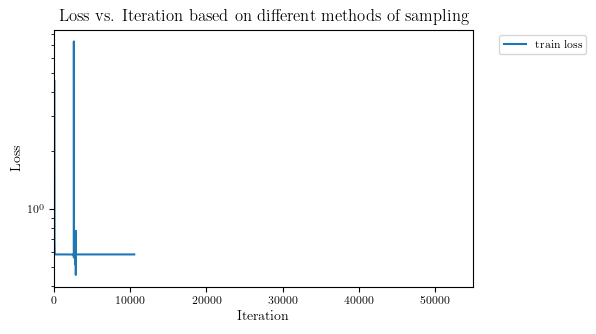

In [ ]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

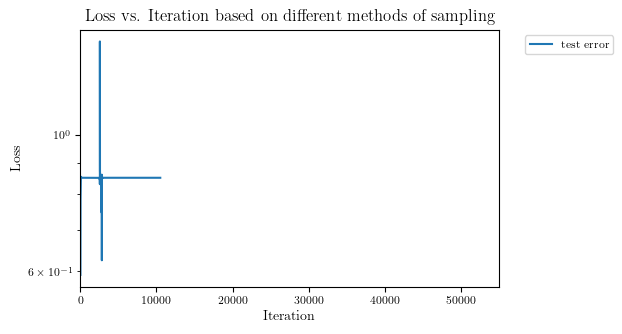

In [ ]:
# print(len(trainloss))
# print(trainloss)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

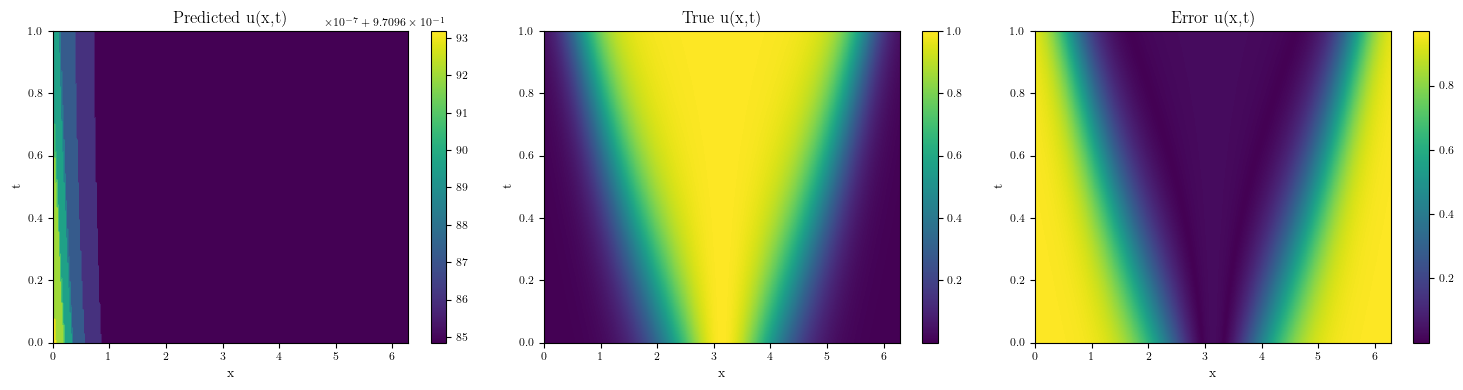

In [ ]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(u_pred, extent=[0, np.pi*2, 1, 0], aspect='auto')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predicted u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(u_test, extent=[0,np.pi*2,1,0], aspect='auto') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(u_pred - u_test), extent=[0,np.pi*2,1,0], aspect='auto') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

## Visualizations

In [ ]:
#进行插值，准备绘制详细预测值
x = np.linspace(0, 2*np.pi, 301)
t = np.linspace(0, 1, 101)

X, T = np.meshgrid(x,t)

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_test, u_pred.flatten(), (X,T), method='cubic')

U_real = griddata(X_test, u_test.flatten(), (X,T), method='cubic')


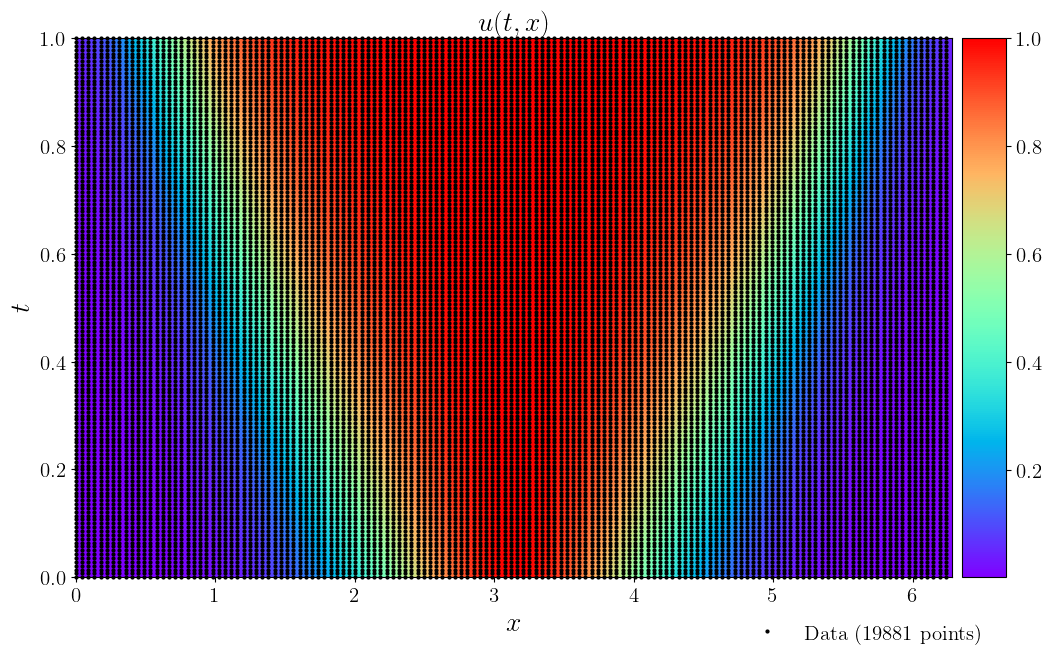

In [ ]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 7)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_real, interpolation='nearest', cmap='rainbow', 
              extent=[x.min(), x.max(), t.min(), t.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图

ax.plot(
    X_f[:,0], 
    X_f[:,1], 
    'ko', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 2,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$x$', size=20)
ax.set_ylabel('$t$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

## Visualizations

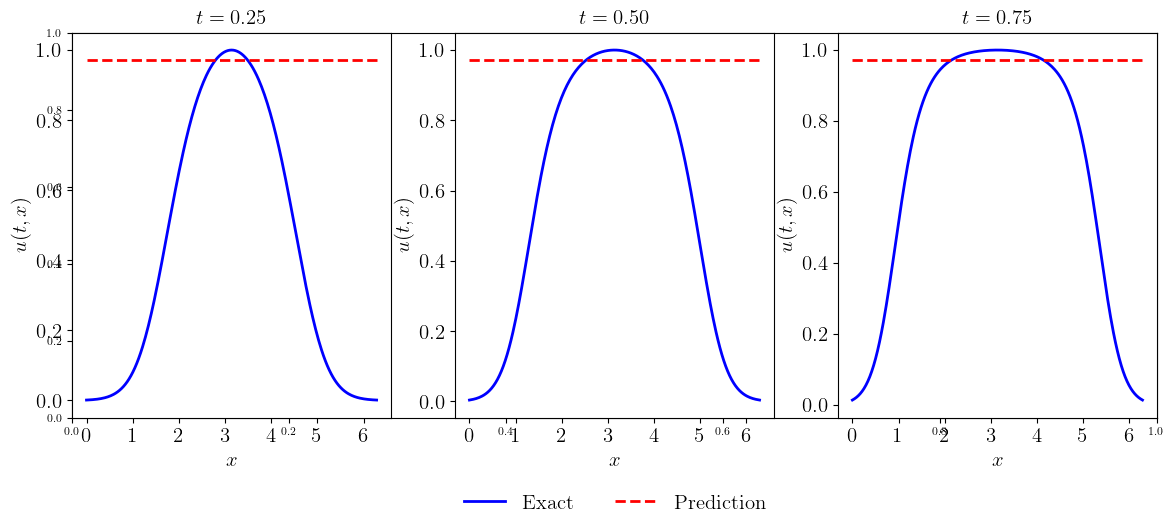

In [ ]:
####### Row 1: u(t,x) slices ################## 


fig = plt.figure(figsize=(14, 5))#这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽14英寸高10英寸
ax = fig.add_subplot(111)#在图形的1*1网格的第一个位置添加一个子图

gs1 = gridspec.GridSpec(1, 3)#创建一个1×3的网络，用于存放子图
# gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)  #更新该网络的参数，第一个表示子图的顶部位置为0.567，第二个参数表示子图的底部位置为0.33，第三个表示子图左侧的位置为0.1，第四个参数表示子图的右侧位置为0.9，第五个参数表示子图之间的宽度为0.5

ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。
#绘制了两条线，一条表示精确值，一条表示预测值
ax.plot(x,u_test[25,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值     
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$')    #设置子图的y轴的标签为u(t,x)
ax.set_title('$t = 0.25$', fontsize = 15) #设置子图的标题为t=0.25，fontsize=10表示字体大小为15
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第一个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第一个子图的y轴的范围为[-1.1,1.1]
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 1]) #在gs1[0,1]指定的位置，也就是网格的第一行第二列，创建了第二个子图，并将返回的axes对象赋值给ax。
ax.plot(x,u_test[50,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值    
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第二个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第二个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.50$', fontsize = 15) #设置子图的标题为t=0.50，fontsize=15表示字体大小为15
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)#设置子图的图例，loc='upper center'表示图例的位置是上方中间，bbox_to_anchor=(0.5, -0.15)表示图例的位置是在子图的中间下方0.15的位置，ncol=5表示图例的列数为5，frameon=False表示不显示图例的边框；最后一个参数设置图例属性，接受字典作为参数，这里表示将图例的字体大小设置为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 2]) #在gs1[0,2]指定的位置，也就是网格的第一行第三列，创建了第三个子图，并将返回的axes对象赋值给ax。
ax.plot(x,u_test[75,:], 'b-', linewidth = 2, label = 'Exact')  #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第三个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第三个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.75$', fontsize = 15) #设置子图的标题为t=0.75，fontsize=15表示字体大小为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。

plt.show() #显示所有打开的图形的函数